In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.animation as animation

%matplotlib widget

In [2]:
# Define functions to get Sobel derivative operators with center value K
def sobel3x3_x(K):
    return np.array([[1], [K], [1]]) @ np.array([[-1, 0, 1]], dtype=np.float64)
def sobel3x3_y(K):
    return np.array([[1], [0], [-1]]) @ np.array([[1, K, 1]], dtype=np.float64)

K = 2
sobel_x = sobel3x3_x(K)
sobel_y = sobel3x3_y(K)

# Return the Lucas-Kanade optical flow given patches at time t and t+1
def lucas_kanade_patch(patch_t, patch_tp1):
    I = patch_t
    
    Ix = cv2.filter2D(I, -1, sobel_x)
    Iy = cv2.filter2D(I, -1, sobel_y)
    It = patch_tp1 - patch_t

    # Elements of structure tensor
    a = np.sum(Ix ** 2)
    b = c = np.sum(Ix * Iy)
    d = np.sum(Iy ** 2)
    det = a * d - b * c

    if det == 0:
        return 0, 0
    invdet = 1/det

    x1 = -np.sum(Ix * It)
    x2 = -np.sum(Iy * It)

    # Basically (vx, vy) = (Structure Tensor)^{-1} (x1, x2)
    vx = invdet * (d * x1 - b * x2)
    vy = invdet * (-c * x1 + a * x2)
    return vx, vy

def lucas_kanade_optical_flow(I_t, I_tp1, patch_size=3):
    S = patch_size
    vx_mat = np.zeros_like(I_t)
    vy_mat = np.zeros_like(I_t)
    for i in range(0, I_t.shape[0] - S, S):
        for j in range(0, I_t.shape[1] - S, S):
            patch_t = I_t[i:i+S, j:j+S]
            patch_tp1 = I_tp1[i:i+S, j:j+S]
            vx, vy = lucas_kanade_patch(patch_t, patch_tp1)
            vx_mat[i:i+S, j:j+S] = vx
            vy_mat[i:i+S, j:j+S] = vy
    return vx_mat, vy_mat

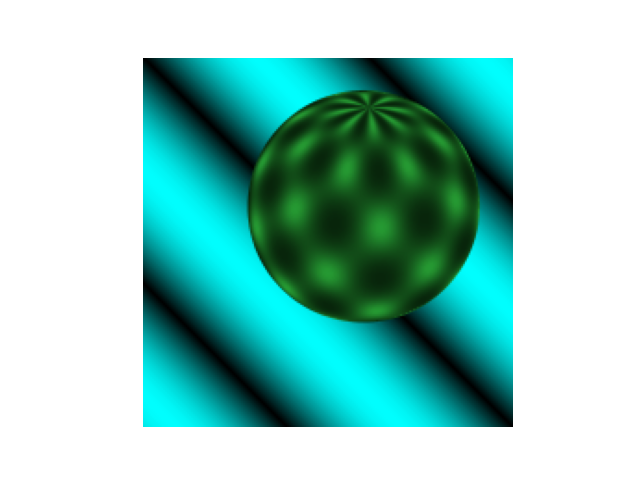

In [3]:
image_0 = cv2.imread(f'assets/sphere/sphere.0.ppm')
I_0 = cv2.cvtColor(image_0, cv2.COLOR_BGR2GRAY).astype(np.float64)

fig, ax = plt.subplots()
ims = []
for i in range(20):
    image = cv2.imread(f'assets/sphere/sphere.{i}.ppm')
    im = ax.imshow(image, animated=True)
    if i == 0:
        ax.imshow(image)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

plt.axis('off')
plt.show()

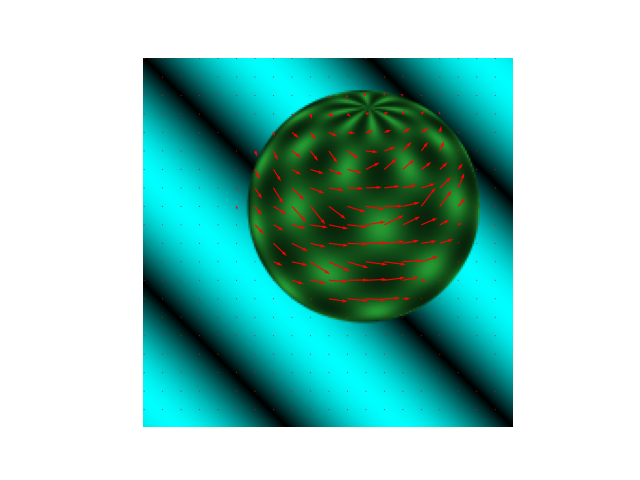

In [4]:
# We add the velocity vectors of all the frames to get average velocity
patch_size = 10
for t in range(19):
    image_t = cv2.imread(f'assets/sphere/sphere.{t}.ppm')
    image_tp1 = cv2.imread(f'assets/sphere/sphere.{t+1}.ppm')
    I_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2GRAY).astype(np.float64)
    I_tp1 = cv2.cvtColor(image_tp1, cv2.COLOR_BGR2GRAY).astype(np.float64)
    vx_mat_curr, vy_mat_curr = lucas_kanade_optical_flow(I_t, I_tp1, patch_size=patch_size)
    if t == 0:
        vx_mat = vx_mat_curr
        vy_mat = vy_mat_curr
    vx_mat += vx_mat_curr
    vy_mat += vy_mat_curr

G = patch_size  # velocity vector mesh with grid width G

fig, ax = plt.subplots()
ims = []
for i in range(20):
    image = cv2.imread(f'assets/sphere/sphere.{i}.ppm')
    im = ax.imshow(image, animated=True)
    if i == 0:
        ax.imshow(image)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
X, Y = np.meshgrid(np.arange(0, I_0.shape[1], G), np.arange(0, I_0.shape[0], G))
plt.quiver(X, Y, vx_mat[::G, ::G], vy_mat[::G, ::G], scale=100, color='red')
plt.axis('off')
plt.show()